==============================================================================================
# Practicum 6 

==============================================================================================

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **english**.

- The deliverable must be a file named **P6_Student1_Student2.zip** that includes:
    - The notebook P6_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline: December 22th, 23:00 h**

==============================================================================================

## Imports

In [45]:
from time import time
import os

import numpy as np
from numpy import unique
import matplotlib.pyplot as plt

import skimage
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import io

# Split dataset into training and test
from sklearn.model_selection import train_test_split 

### FACE DETECTION
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.transform import integral_image

### FACE RECOGNITION
# Load the dataset
from sklearn.datasets import fetch_lfw_people 
# Classification and results
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report 

# others imports
from skimage.io import imread
import random
from skimage.transform import integral_image
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance

In [46]:
def show_img(image,title):
    """
    function that displays a single image with its corresponding title
        image: image we want to display
        title: title of the image we want to display
    """
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [47]:
def show_images(images,titles,ncols):
    """
    function that displays a set of images
        images: list of images
        titles: list of image titles
        ncols: number of columns
    """
    nrows = len(images)//ncols
    
    if nrows == 1:
        show_row_of_images(images,titles)
    
    elif ncols == 1:
        for i in range(len(images)):
            show_img(images[i],titles[i])
    else:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(15,10))

        index = 0
        for i in range(nrows):
            for j in range(ncols):
                ax = axs[i,j]
                ax.imshow(images[index],cmap='gray')
                ax.set_title(titles[index])
                ax.axis('off')
                index += 1

        plt.show()

In [48]:
def show_row_of_images(images,titles):
    """
    function that displays a row of images
        images: list of images
        titles: list of image titles
    """
    canvas, axs = plt.subplots(nrows=1, ncols=len(images), figsize=(12,8))
    
    for index,image in enumerate(images):
        ax = axs[index]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(titles[index])

==============================================================================================
## Haar-like features applied for face detection
==============================================================================================

### What is a Haar-like feature?

Haar-like feature descriptors were successfully used to implement the first real-time face detector. In this laboratory we will see an example illustrating the extraction, selection, and classification of Haar-like features to detect faces vs. non-faces.

Documentation [Haar-like feature skimage](https://scikit-image.org/docs/0.14.x/auto_examples/xx_applications/plot_haar_extraction_selection_classification.html)

Haar-like features are features extracted from the images to recognize objects. These features are normally used in face recognition. The key to face recognition is to detect the relevant features of humans such as eyes, lips, or nose. 


<img src="notebook_images/haar-like.PNG" width=400, height=400>

Try to guess where in the face image we expect to detect an edge, line or another facial feature and what would be the most appropriate Haar-feature for them? 

<img src="notebook_images/haar-like1.PNG" width=500, height=500>


A real application would be:

<img src="notebook_images/face.PNG" width=300, height=300>


To describe the face, we can apply convolutions with Haar features. What alternative to the convolution with Haar-features, do you know?


### 1. Building integral image

Compute all the Haar-like features (we can define up to 16000 million masks), can be a slow process. To compute it faster, we are going to use the integral images (instead of convolutions). It is very useful because we are able to save all the sums and substrations of image rectangles to avoid computing all the features every time.

When creating an Integral Image, we need to create a Summed Area Table. What does represent any point (x,y) in this table?

<img src="notebook_images/integral_image.PNG" width=250, height=2500>

An example :

<img src="notebook_images/integral_image1.PNG" width=400, height=400>

To easy the computation of Haar features, the integral image must have an additional row and column full of zeros (first row and first column). Why?

**1.1** Build a function `to_integral_image` that computes the integral image of an input (2D) array. The integral image must have an additional row and column full of zeros (first row and first column).
Make sure that the values of the integral image are correct.

Try your function using a `5x5` random grayscale image. Visualize both the original random image and the integral one.

In [49]:
def to_integral_image(array):
    l = array.shape[0] + 1
    w = array.shape[1] + 1
    
    # add additional row and column of zeros
    integral_image = np.zeros((l,w))
    
    for i in range(l-1):
        for j in range(w-1):
            # in order to ensure that the indexes does not cross the bounds
            integral_image[i+1,j+1] = integral_image[i, j + 1] + integral_image[i + 1, j] - integral_image[i, j] + array[i, j]
    return integral_image

To make sure that the values of the integral image are correct, compute the following tests:

 - `img_array.sum() == ii_img_array[-1,-1]`
 - `img_array[0,:].sum() == ii_img_array[1,-1]`

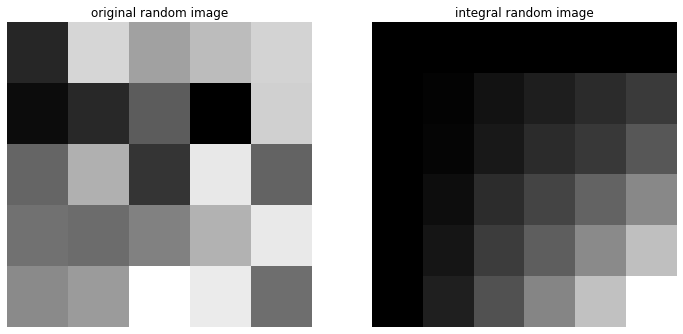

In [50]:
# create a 5x5 random gryascale image
img_array = np.random.randint(256,size = (5,5))
ii_img_array = to_integral_image(img_array)

assert img_array.sum() == ii_img_array[-1,-1], "to_integral_image failed"
assert img_array[0,:].sum() == ii_img_array[1,-1], "to_integral_image failed"

show_images([img_array,ii_img_array],['original random image','integral random image'],2)

**1.2** Let's check in real images. Choose an image from the directory ``./faces``, visualize both the original and the integral image, and make the same test that in the previous question.

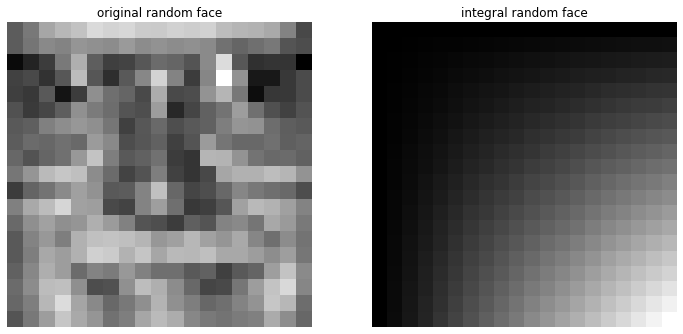

In [51]:
directory_faces = './faces/'
face_images = [imread(os.path.join(directory_faces, filename)) for filename in os.listdir(directory_faces)]

random_face = face_images[random.randrange(len(face_images))]
integral_random_face = to_integral_image(random_face)

show_images([random_face,integral_random_face],['original random face','integral random face'],2)

What do the following lines mean? How can you explain this?

- `img_array.sum() == ii_img_array[-1,-1]`
- `img_array[0,:].sum() == ii_img_array[1,-1]`
- `ii_img_array[0,-1].sum() == 0`
 

>> theses lines mean ababbaab

**1.3:** Alternatively to your own function, you can use the ``integral_image()`` function from ``skimage.transform``. Compare (numerically) the result obtained using your funtion and that obtained using the function provided by skimage.

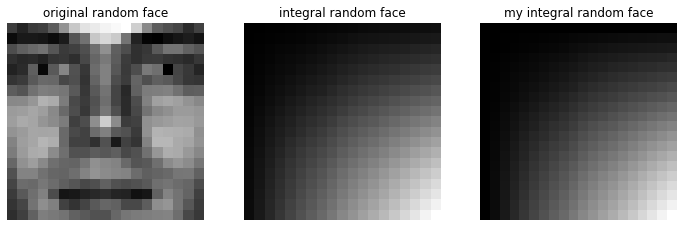

In [52]:
random_face = face_images[random.randrange(len(face_images))]
my_integral_random_face = to_integral_image(random_face)
integral_random_face = integral_image(random_face)

show_images([random_face,integral_random_face,my_integral_random_face],['original random face','integral random face','my integral random face'],3)

## 2. Haar-like features

Let's use the [haar_like_feature()](https://scikit-image.org/docs/0.14.x/api/skimage.feature.html#skimage.feature.haar_like_feature) function from skimage. Check the parameters and the returned value of the ``function haar_like_feature()`` before continuing and **NOTE** that we must use the integral image (**not the real image**) in this function.

*skimage.feature.haar_like_feature(int_image, rint, cint, widthint, heightint, feature_type=None, feature_coord=None)*



###  Extract features

**2.1** Define a function ``extract_feature_image(image, feature_type, feature_coord=None)`` to obtain the Haar-like features, using a given type of features ``feature_types``, from an image. The aim of this function is as simple as to join both `to_integral_image()` and `haar_like_feature()`functions.

Try your function using the choosing image from *1.4*. You should obtain a feature vector. Print the vector shape.

**Note:** You can give an array with a set of feature types to the `haar_like_feature()` function and it will compute all the corresponding features. We **do not** need to give each time only one feature.


In [53]:
feature_types = ['type-2-x', 'type-2-y',
                 'type-3-x', 'type-3-y',
                 'type-4']

In [54]:
def extract_feature_image(image, feature_type, feature_coord=None):
    integral_image = to_integral_image(image)
    feature = haar_like_feature(integral_image, 0, 0, integral_image.shape[0], integral_image.shape[1], feature_type=feature_type, feature_coord=feature_coord)
    return feature

**2.2** Plot a Haar-like feature on an image:

To visualize Haar-like features on an image, we need the fuctions, provided by skimage, ``haar_like_feature_coord()``, which computes the coordinates of Haar-like features, and ``draw_haar_like_feature()``, used to visualize that features.

Before continuing, please, **check the online documentation of the two functions**

- [*haar_like_feature_coord(width, height, feature_type=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.haar_like_feature_coord)

- [*draw_haar_like_feature(image, r, c, width, height, feature_coord, color_positive_block=(1.0, 0.0, 0.0), color_negative_block=(0.0, 1.0, 0.0), alpha=0.5, max_n_features=None, random_state=None)*](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.draw_haar_like_feature)

Define a function ``plotFeatures``  to visualize Haar-like features on an images, given a array of feature types ``feature_types``. The aim of this exercise is, similarly to the previous one, to merge both `haar_like_feature_coord()` and `draw_haar_like_feature()` functions. Try your own function using the choosing image from *1.4* as follows:

<img src="notebook_images/image1.png" width=600, height=300>

In [55]:
def plotFeatures(image, feature_type, feature_coord=None):
    images = []
    print('The different Haar-like feature descriptors')
    for feat_t in feature_type:
        # computes the coordinates of Haar-like features
        coord, _ = haar_like_feature_coord(image.shape[0], image.shape[1], feat_t)
        img = draw_haar_like_feature(image, 0, 0, 6, 6, coord, max_n_features=1,random_state=0)
        images.append(img)
    show_images(images,feature_type,5)

The different Haar-like feature descriptors


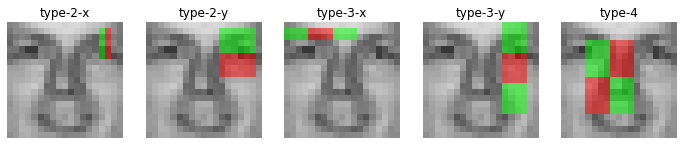

In [56]:
# obtain a random face
random_face = face_images[random.randrange(len(face_images))]

plotFeatures(random_face,feature_types)

## 3 Face detection using an Adaboost

**3.1** Read all the images from the directories ``./faces`` and ``./nonfaces`` and build an array with the all the features. 

Futhermore, build the class labels vector ``y`` with the label of all the images

In [57]:
directory_faces = './faces/'
face_images = [imread(os.path.join(directory_faces, filename)) for filename in os.listdir(directory_faces)]
directory_nonfaces = './nonfaces/'
nonface_images = [imread(os.path.join(directory_nonfaces, filename)) for filename in os.listdir(directory_nonfaces)]

**3.2** Using the ``train_test_split()`` function from `sklearn.model_selection`, divide the dataset into *train* and *test* sets. The test size must be the 30% (i.e. 0.3) of the whole dataset.

[*sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [58]:
all_images = face_images + nonface_images
features = [extract_feature_image(img,feature_types) for img in all_images]

In [59]:
# y = range(len(all_images))
y = np.concatenate([np.zeros(len(face_images), dtype=int), np.ones(len(nonface_images), dtype=int)])
y_names = ["Face", "No face"]

In [60]:
features_train, features_test, y_train, y_test = train_test_split(features, y, test_size=0.3)

**3.3** Train an Adaboost classifier using `AdaBoostClassifier()`from `sklearn.ensemble`.

[*sklearn.ensemble.AdaBoostClassifier(n_estimators=50, learning_rate=1.0)*](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

What is an Adaboost? How it works?

>>  Adaboost, from Adaptive and Boosting, is a meta-learning algorithm or method for mainly classification tasks. Mostly used by binary results. It joins several weak classifiers , such as decision trees, to form a stronger one. You start by creating a model from the training data. Then, you create a second model from the previous one by trying to reduce the errors from the previous model. The iteration continues, and models are added sequentially, each correcting its predecessor, until the training data is predicted perfectly or the maximum number of models have been added.

In [61]:
clf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0)

**3.4** Evaluate the accuracy of the Adaboost classifier using the *predict* and *score* methods of the classifier. What are these methods doing?

In [62]:
def evaluate(clf,X,y,X_test,y_test):
    clf.fit(X,y)
    clf.predict(X_test)
    
    return clf.score(X_test, y_test, sample_weight=None)

In [63]:
print("Accuracy of train set: ", evaluate(clf,features_train,y_train,features_test,y_test))

Accuracy of train set:  0.9523809523809523


In [64]:
print(len(features_train))
print(len(features_train[0]))

47
78134


Change the parameter ``n_estimators`` and see what happens. Does it improve?

In [65]:
clf2 = AdaBoostClassifier(n_estimators=100, learning_rate=1.0)
print("Accuracy of train set: ", evaluate(clf2,features_train,y_train,features_test,y_test))

Accuracy of train set:  0.9523809523809523


>> For larger n_estimators, larger number of weak learnes, so we can adjust that parameter to optimize the result, and in that case, it actually have improved. But costs more time.


**3.5** The method ``feature_importances_`` of the Adaboost is giving the importance of the features. Implement a function to visualize the 10 most important features on an image of a face on your choice. 

In [83]:
def feature_importance(clf):
    # get the features importances from Adaboost
    importances = clf.feature_importances_
    
    # get the 10 most important features indices
    top_10 = importances.argsort()[-10:][::-1]
    
    feature_importances = clf.feature_importances_[top_10]
    plt.bar(range(len(feature_importances)),feature_importances)
    plt.xticks(range(len(feature_importances)),top_10)
    plt.ylabel("Importance")
    plt.xlabel("Feature")
    plt.title("10 most important features")

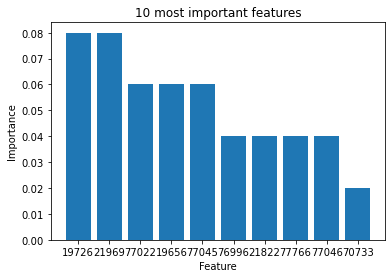

In [84]:
# obtain a random face
random_face = face_images[random.randrange(len(face_images))]
feature_importance(clf)

**3.6 (Optional)** Implement the Adaboost training the model using a different number of features. For instace,  just using 1 type of feature, 2 types, and 3 types. Plot the results comparing the precision. Draw conclusions about the results

In [67]:
#your solution


==============================================================================================
## Principal Component Analysis (PCA) applied for face recognition
==============================================================================================

### Dimensionality and redundancy

Imagine we have a dataset with 100x100 pixel images, it means we have 10000 dimensions. We want to construct a low-dimensional linear subspace that best explains the variation in the set of face images (**Eigenfaces space**)

<img src="notebook_images/subspace.PNG" width=200, height=200>

Each image has m rows and n columns and defines a vector of (mxn) elements. We need to choose the most valuable pixels in order to avoid compute all dimensions. 

<img src="notebook_images/feature_vector.PNG" width=800, height=400>

We look for a transformation of the original space to a smaller (M << (mxn)) where faces are represented with their coordinates in this new space R.

To reduce the dimensionality retaining the information necessary to classify and recognize, we are going to use the **Eigenfaces method** 

### How to build a reduced space?

To build this new space, we are going to use the **Principal Component Analysis**. Given a large space, the PCA looks for the minimum number of axes that best represents the variation of the data.

<img src="notebook_images/pca.PNG" width=400, height=400>

The eigenvectors of the covariance matrix define the axis of maximum variance and the eigenvalues give a measure of the variance of the data. 

1. Construct the vector in the (m x n)-dimensional space R given M images of size (m x n).

2. Compute the mean image 

<center>
$\overline{X}=\frac{1}{M}\sum_{i=1}^{M} X_i$
</center>

3. Construct the covariance matrix. Due to $A \times A^T$ is too large, instead of using $A \times A^T$ to compute its eigenvectors, we are going to compute the eigenvectors of $A^T \times A$.

<img src="notebook_images/covariance_image.PNG" width=500, height=500>

4. Extract the eigenvectors (the base of the new space) and their eigenvalues and project faces in the new space to apply the classifier (knn)


## 4. Load and prepare data

Let's use the [Labeled Faces in the Wild (LFW)](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) people dataset (classification).

Face dataset features:

- Classes: 5749

- Samples total: 13233

- Dimensionality: 5828

- Features: real, between 0 and 255


*sklearn.datasets.fetch_lfw_people(data_home=None, funneled=True, resize=0.5, min_faces_per_person=0, color=False, slice_=(slice(70, 195, None), slice(78, 172, None)), download_if_missing=True, return_X_y=False)*



*Please, check the parameters and returned value by ``lethc_lfw_people()`` before continuing.*

**4.1** Load the dataset, obtaining only those cases where there are, at least, 100 images. Check the final number of images, image shapes and labels of the images.

In [68]:
lfw_people = fetch_lfw_people(min_faces_per_person=100,slice_=(slice(70, 195, None), slice(78, 172, None)), resize=0.5)

In [69]:
"""print(type(lfw_people))
print(type(lfw_people.data))
print(type(lfw_people.images))
print(lfw_people.data)
print(lfw_people.images.shape)
#print(lfw_people.images)
print(type(lfw_people.target))
print(lfw_people.target)
print(len(lfw_people.target))
print(lfw_people.target.max())
print(lfw_people.target.min())
print((lfw_people.target_names))"""

'print(type(lfw_people))\nprint(type(lfw_people.data))\nprint(type(lfw_people.images))\nprint(lfw_people.data)\nprint(lfw_people.images.shape)\n#print(lfw_people.images)\nprint(type(lfw_people.target))\nprint(lfw_people.target)\nprint(len(lfw_people.target))\nprint(lfw_people.target.max())\nprint(lfw_people.target.min())\nprint((lfw_people.target_names))'

In [85]:
def check_parameters(lfw_people):
    # Get the number of images and their shape
    n_samples, h, w = lfw_people.images.shape
    
    # Number of features
    n_features = lfw_people.data.shape[1]
    
    # Labels associated to each face image. 
    y = lfw_people.target # The label is from 0 to 5 because we have five classes in that case
    n_classes = lfw_people.target_names.shape[0]
    
    # Print the information
    print("Number of images:", n_samples)
    print("Shape of images:", str((h,w)))
    print("Label of the images:", y)
    print("Number of features:", n_features)
    print("Number of classes:", n_classes)
check_parameters(lfw_people)

Number of images: 1140
Shape of images: (62, 47)
Label of the images: [2 3 1 ... 4 2 4]
Number of features: 2914
Number of classes: 5


**4.2** Plot an image frome each example, with its name as the title of the image.

<img src="notebook_images/example.png" width=500, height=500>

In [88]:
def plot_all_type_faces(lfw_people):
    '''
    Function that plot one image of each class from a peoplr data set
        lfw_people: data set (of people)
    '''
    # get the number of classes
    n_classes = lfw_people.target_names.shape[0]
    
    images = []
    titles = []
    
    # iterate over the number of classes to get one image of each class
    for i in range(n_classes):
        # get a random index from the current class
        index = random.choice(np.where(lfw_people.target == i)[0])
        # get its corresponding image and title
        image = lfw_people.images[index]
        title = lfw_people.target_names[i]
        # Saved them
        images.append(image)
        titles.append(title)
            
    # Plot them all
    show_images(images,titles, len(titles))

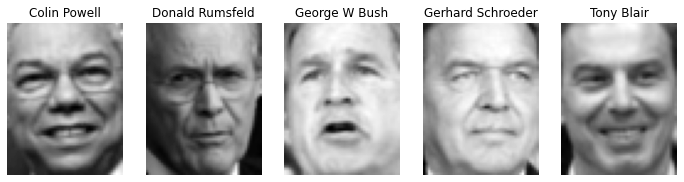

In [89]:
plot_all_type_faces(lfw_people)

**4.3** Divide the dataset into train and test set (0.7/0.3). 

Hint: use the train_test_split function.

In [97]:
X = lfw_people.data
y = lfw_people.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## 5. Compute PCA

[*class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)*](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

The principal components measure deviations about this mean along orthogonal axes.

**5.1** Create a PCA object, using the training set and a 150 components

In [98]:
# Build the PCA with 150 components using the X_train data set
pca = PCA(n_components=150, svd_solver="randomized", whiten=True).fit(X_train)

Plot the accumated variance of the components. 

**Hint:** Use the returned `explained_variance_ratio_`.

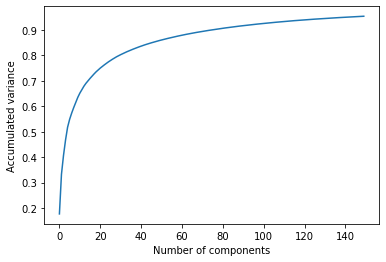

Acumulated explained variance: 0.9534487724304199


In [101]:
# get the eigenvalues
eigenvalues = pca.explained_variance_ratio_

accumulated_variance = np.cumsum(eigenvalues)
plt.plot(accumulated_variance)
plt.xlabel('Number of components')
plt.ylabel('Accumulated variance')
plt.show()

print(f"Acumulated explained variance: {accumulated_variance[-1]}")

**5.2** One interesting part of PCA is that it computes the average face, which can be interesting to examine. 

Plot the average face, using the method `mean_` of the PCA object.

**Hint:** The average face need to be reshaped in order to visualize it properly

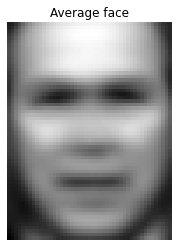

In [104]:
mean_face = pca.mean_.reshape(lfw_people.images[0].shape)
show_img(mean_face,'Average face')

**5.3** Furhtermore, we can check all the principal components (i.e. eigenfaces) considering the corresponding importance. Visualize 30 principal eigenfaces.

<img src="notebook_images/eigenfaces.png" width=500, height=500>

Note that the base components are ordered by their importance. We see that the first few components seem to primarily take care of lighting conditions; the remaining components pull out certain identifying features: the nose, eyes, eyebrows, etc...

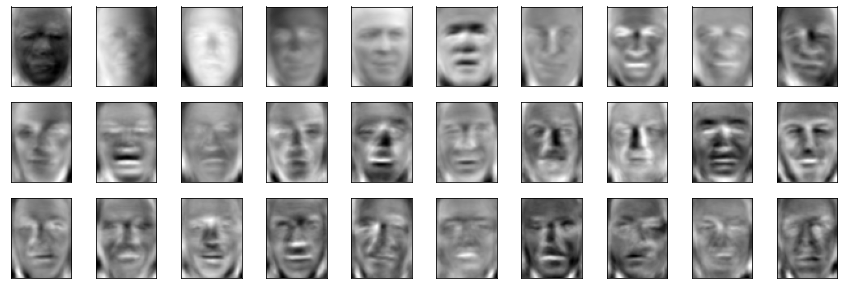

In [111]:
def plot_principal_eigenfaces(pca, n_eingenfaces = 30):
    # get the eigenfaces from pca and reshape them
    eigenfaces = pca.components_[:n_eingenfaces]
    
    fig, axes = plt.subplots(3, 10, figsize=(15,5), subplot_kw={'xticks':[], 'yticks':[]})           
    for i, ax in enumerate(axes.flat):
        ax.imshow(eigenfaces[i].reshape(lfw_people.images[0].shape), cmap='gray')

plot_principal_eigenfaces(pca)

**5.4** Project both the training and test set onto the PCA basis, using the method `transform()` of the PCA object.

In [114]:
# Project the training and test sets onto the PCA basis
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Do you need to apply the same to the variable y?

> Knowing that the resulting arrays X_train_pca and X_test_pca will contain the projections of the training and test sets onto the PCA basis, respectively. We don't need to project the y, we just need apply to the features. The labels aren't affected by the PCA transformation and so don't need to be projected.

**5.5**  These projected components correspond to factors in a linear combination of component images such that the combination approaches the original face. 

Choose one of the images and try to recompose from its first 10 most important corresponding eigenfaces. **Note that** we need to use the average face as the basis to agregate the rest of the components.


<img src="notebook_images/eigenfaces_image.PNG" width=300, height=300>


In [124]:
def composite_face(index, pca, X_train_pca, lfw_people, n_eingenfaces = 10):
    
    # reconstruct the original data from the reduced data
    face = pca.inverse_transform(X_train_pca[index]).reshape(lfw_people.images[0].shape)
    # get its corresponding weights
    face_weights = X_train_pca[index][:n_eingenfaces]
    
    # get the first 10 eigenvectors from the PCA object
    eigenfaces = pca.components_[:n_eingenfaces]
    
    # recompose the image by adding the weighted average face to the weighted eigenvectors
    reconstructed_face = np.dot(face_weights, eigenfaces).reshape(lfw_people.images[0].shape)
    
    show_row_of_images([face, reconstructed_face], ["Reconstructed Face from PCA", "Reconstructed face"])

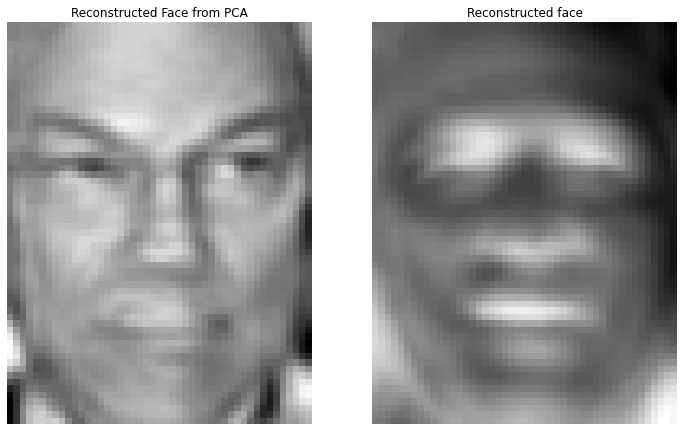

In [125]:
# get a random index of a face from our trianing data
random_index = random.randint(0, len(X_train_pca) - 1)
composite_face(random_index, pca, X_train_pca, lfw_people)

## 6. Train a classifier

**6.1** Train an Adaboost classifier using the PCA features. Show the results obtained with the test set.
Use the `score` method of the Adaboost model.

In [126]:
adaboost = AdaBoostClassifier()

In [128]:
score = evaluate(adaboost, X_train_pca, y_train, X_test_pca, y_test)
print(f'Test set score: {score}')

Test set score: 0.6461988304093568


**6.2** We can quantify this effectiveness using one of several measures from sklearn.metrics. First we can do the classification report, which shows the precision, recall and other measures of the “goodness” of the classification.

*sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')*

*Please, check the parameters and returned value by ``classification_report()`` before continuing.*

Print the classification report obtained during the training of the Adaboost model.

In [131]:
# Generate a classification report for the train data with pca
y_pred = adaboost.predict(X_test_pca)

# The parameter y_true was the real y_train labels and y_pred is the label the classifier makes
print(classification_report(y_test, y_pred, target_names=lfw_people.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.61      0.49      0.54        69
  Donald Rumsfeld       0.65      0.53      0.59        32
    George W Bush       0.71      0.82      0.76       171
Gerhard Schroeder       0.68      0.38      0.49        39
       Tony Blair       0.35      0.45      0.39        31

         accuracy                           0.65       342
        macro avg       0.60      0.54      0.56       342
     weighted avg       0.65      0.65      0.64       342



Please, explaing what is:
- **accuracy (score)**: is a measure of how well a classifier performs. It is the ratio of the number of correct predictions made by the classifier to the total number of predictions made.
<center>
${accuracy}=\frac{number.of.correct.preditions}{number.of.total.predictions}$
</center>
- **precision**: is a measure of the accuracy of the classifier when it predicts the positive class. It is the ratio of the number of true positives (predictions that are actually positive) to the total number of predicted positives (predictions that are either true or false).
<center>
${precision}=\frac{True.Positive}{True.Positive + False.Positive}$
</center>
- **recall**: is a measure of the classifier's ability to find all the positive instances. It is the ratio of the number of true positives to the number of actual positive instances.
- **f1-score**: is a harmonic mean of precision and recall, with a higher score indicating a better balance between precision and recall.
<center>
${precision}=\frac{2*recall*precision}{recall+precision}$
</center>
- **support**: is the number of samples of the true response that lie in that class.
- **macro avg**: is the average of the precision, recall, and F1 score across all classes. It does not take into account the relative class sizes, so it can be affected by imbalanced class sizes.
- **weighted avg**: is the average of the precision, recall, and F1 score across all classes, with each class’s score weighted according to the number of samples in that class. This can be useful when you have imbalanced class sizes, as it gives more weight to the scores of the larger classes.


**6.3** Train an Adaboost classifier, without PCA, using the training set. Show the results using the `score` method of the Adaboost model and the corresponding classification report.

In [132]:
# Evaluate the classifier on the test data
score = evaluate(adaboost, X_train, y_train, X_test, y_test)

# Generate a classification report for the train data
y_pred = adaboost.predict(X_train)
report = classification_report(y_train, y_pred, target_names=lfw_people.target_names)

print(f'Train set score: {score}')

print("Report train set,\n", report)

Train set score: 0.5730994152046783
Report train set,
                    precision    recall  f1-score   support

     Colin Powell       0.81      0.56      0.66       167
  Donald Rumsfeld       0.71      0.40      0.51        89
    George W Bush       0.66      0.87      0.75       359
Gerhard Schroeder       0.68      0.40      0.50        70
       Tony Blair       0.50      0.51      0.51       113

         accuracy                           0.66       798
        macro avg       0.67      0.55      0.59       798
     weighted avg       0.68      0.66      0.65       798



In [133]:
%%time
score = evaluate(adaboost, X_train, y_train, X_test, y_test)

Wall time: 9.09 s


In [134]:
%%time
score = evaluate(adaboost, X_train_pca, y_train, X_test_pca, y_test)

Wall time: 690 ms


**Questions**

- Does computing time change using PCA? How?
- Which of both (with and without PCA) does give better results?
- How does the result change if we change the number of components in PCA?
- How does the result change if we change the number of estimators in the Adaboost?

> Yes, as we can see in the two cases. We need less time using PCA, that occurs because we transformed the training data using PCA. So now we are working and making calculations in a smaller space, which can make the model more efficient and improve its performance. But using PCA can remove some important information.

> When the number of components change, means we are changing the dimension of information we are using. So for larger number of components we can make better matches and take higher positive classifications, but don't forget somtimes we can go for overfitting as the dimension is too big (because we have catched some not important information). So for that we need to compute for different number of components and test them all for take the betters results and model.

> The number of estimators (also known as the "number of weak learners") in an AdaBoost model determines the complexity of the model. In general, increasing the number of estimators will result in a more complex model that may be able to capture more of the patterns in the data, but it may also lead to overfitting. But, In general, increasing the number of estimators will result in a more complex model that may be able to capture more of the patterns in the data, but it may also lead to overfitting. So as the previous questions we will try for different values and choose the best one for our data set.

**6.4 (Optional)** Repeat the experiment using a different number of components. 

For instance, instead of using 150 components, try using 10, 25, 50, 200, 500... at your election. These numbers are just orientative. 

- How much variance is acummulated using the different number of components.
- The result is better using... how many components? 
- Does time change using a different numbero of components?

> The variance is the amount of information that is kept after the PCA transformation, more components imply more variance accumulation. A greater amount of variance can be helpful if the data provider is useful for making good predictions, but can be negative to the performance on new data if it leads to overfitting.

> As we can see, the best result is when using 50 components, with an accuracy of 0.6.

> Yes, a larger amount of components take a greater amount of training time because it requires more computation to tune all the parameters.

In [135]:
n_components = [10, 50, 500]

In [136]:
adaboost2 = AdaBoostClassifier()

In [137]:
for i in range(len(n_components)):
    pca = PCA(n_components=n_components[i]).fit(X_train)

    # We transform into PCA dimension
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Evaluate the classifier on the test data
    score = evaluate(adaboost2, X_train_pca, y_train, X_test_pca, y_test)

    # Generate a classification report for the test data
    y_pred = adaboost2.predict(X_test_pca)
    report = classification_report(y_test, y_pred, target_names=lfw_people.target_names)

    print(f'Test set score: {score}')
    print("Report test set,\n", report)
    print("\n")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Test set score: 0.4678362573099415
Report test set,
                    precision    recall  f1-score   support

     Colin Powell       0.42      0.45      0.43        69
  Donald Rumsfeld       0.31      0.16      0.21        32
    George W Bush       0.61      0.65      0.63       171
Gerhard Schroeder       0.09      0.05      0.06        39
       Tony Blair       0.23      0.35      0.28        31

         accuracy                           0.47       342
        macro avg       0.33      0.33      0.32       342
     weighted avg       0.45      0.47      0.45       342



Test set score: 0.6052631578947368
Report test set,
                    precision    recall  f1-score   support

     Colin Powell       0.64      0.46      0.54        74
  Donald Rumsfeld       0.53      0.28      0.37        32
    George W Bush       0.62      0.84      0.71       160
Gerhard Schroeder       0.55      0.34      0.42        35
       Tony Blair       0.53      0.44      0.48        41

  

## 7. Recognize a new face example using the learned model

**7.1** Try your both models using the test set. 

Predict the labels using the Adaboost model, with and without PCA, and plot the images with the corresponding label as title.

<img src="notebook_images/prediction.png" width=300 height = 300>

In [138]:
def prediction(random_indexes, adaboost, X_train, y_train, X_test, y_test, lfw_people, pca=None):
    # Need to fit the adaboost in case of PCA or not
    adaboost.fit(X_train, y_train)
    # For each image we take the prediction and 
    predicts = adaboost.predict(X_test[random_indexes])
    
    # In case we use PCA, as we don't have the original image data, we can recover it from pca but maybe we lose information
    if pca:
        X_recovered = pca.inverse_transform(X_test)
        
    fig, axes = plt.subplots(len(random_indexes)//4, 4, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})           
    for i, ax in enumerate(axes.flat):
        ax.set_title(f'Predicted: {lfw_people.target_names[predicts[i]]} \nTrue: {lfw_people.target_names[y_test[random_indexes[i]]]}')
        if pca==None:
            ax.imshow(X_test[random_indexes[i]].reshape(lfw_people.images[0].shape), cmap='gray')
        else:
            ax.imshow(X_recovered[random_indexes[i]].reshape(lfw_people.images[0].shape), cmap='gray')
    print("Accuracy:", adaboost.score(X_test, y_test))

In [139]:
# Trying the prediction function for 12 random images without PCA
n_test = 12

# The most common as we now is use the training data set for the model and then use the test data set for get results
# For the first test we use the default adaboost classifier
adaboost1 = AdaBoostClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
pca = PCA(n_components=150).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [140]:
# Generate iterations number of indexes for get the images from X_test
random_indexes = random.sample(range(0, len(X_test)), n_test)

Accuracy: 0.5994152046783626
Wall time: 8.71 s


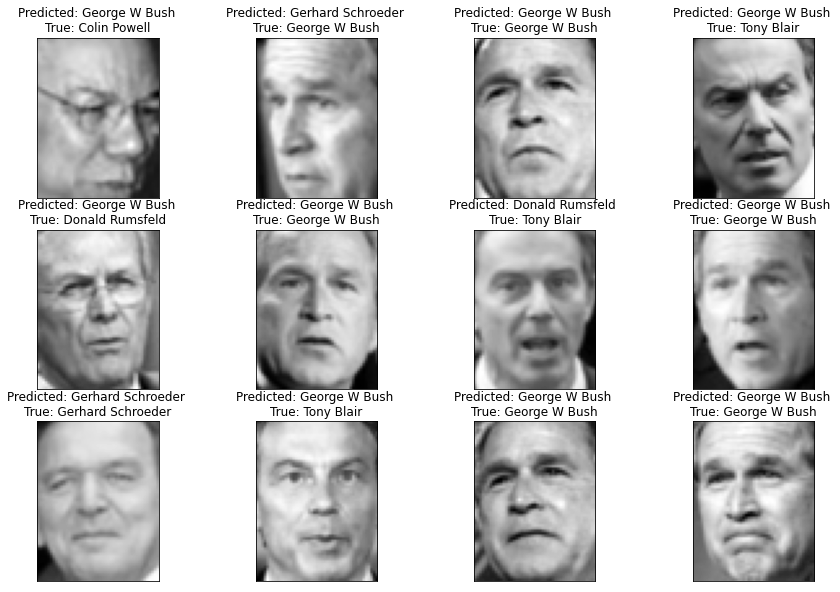

In [141]:
%%time
prediction(random_indexes, adaboost1, X_train, y_train, X_test, y_test, lfw_people)

Accuracy: 0.5877192982456141
Wall time: 824 ms


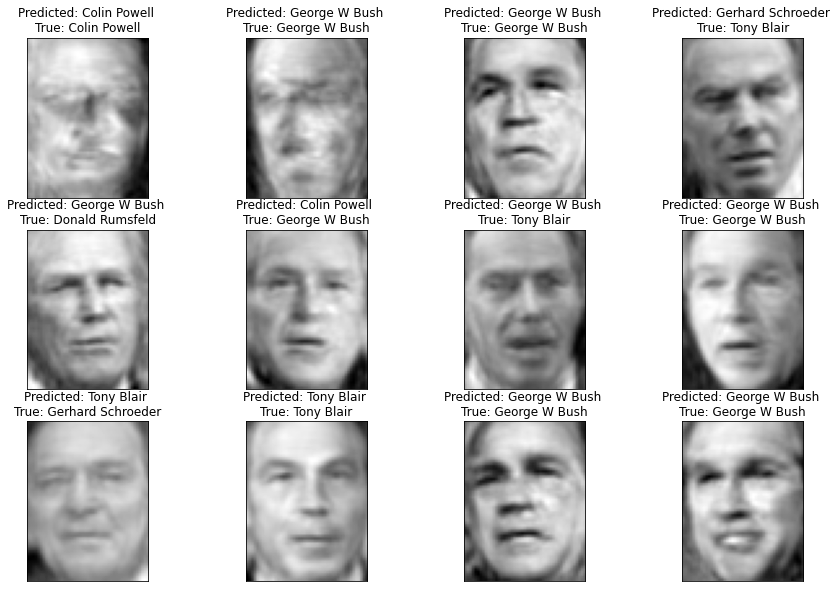

In [142]:
%%time
prediction(random_indexes, adaboost1, X_train_pca, y_train, X_test_pca, y_test, lfw_people, pca)

Which model makes the predictions betters? Try different parameters and comment their effect on the model performance.

> We can see that the time used in the PCA is smaller, because we are working in a smaller dimension and accelerates the classification. And even the results are better in some images, but depending on the adaboost and the pca used can be different.


> Seeing the results, it is usually better using PCA, as the results are similar than without using it and takes less time. But remenber the parameter n_estimators and n_components are 'inverse proportional'. That means with higher n_estimators takes better results and with not a big n_components we work better. And in each case we need not to lead to overfitting (not important information causes undesirable results).

> It's important to see the score (accuracy) from the adaboost function. In that case, using a higher n_estimator (150-200) for adaboost and a smaller n_components (50-100) for PCA. Combine that two we can get not bad results.